In [1]:
import torch
from torch import nn
from torchvision import transforms # Preprocess jpg images
from PIL import Image
import matplotlib.pyplot as plt
device = 'cuda:2'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from dataloader import *
from models import *

2022-02-10 16:02:26.757967: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(The classes should be the same as the ones used for training, otherwise the labels won't match)

In [2]:
flickr8k_path = '/scratch/lt2318-h21-resources/03-image-captioning/data/flickr8k/'
flickr8K_caps = flickr8k_path + 'captions.txt'
flickr8K_imgs = flickr8k_path + 'Images/'
adj_classes, noun_classes, ANP_classes, fn_ANPs = get_imgs_with_ANPs(flickr8K_caps, min_freq=150)

Reading previously saved dictionary of Filename:Adj-Noun-Pairs...
Before filtering: 8091 images with ANPs.
1061 adjs, 3915 nouns.

After filtering: Only keep the adjs or nouns that are annotated in at least 150 images:
26 freq adjs X 101 freq nouns = 2626 possible combinations
6057 images with 704 ANPs containing frequent adjs and nouns.


In [3]:
for x in adj_classes:
    print(x, end=" ")

pink wooden little black white brown small young orange red grassy green blue several yellow large tan snowy blonde rocky purple colorful other old asian haired 

In [4]:
for x in noun_classes:
    print(x, end=" ")

child dress girl building dog road street front hand grass man bench park ground hat glass rope fence beach ball water head side boy wall city shirt jean rock tree collar snow field picture person group people face car mouth toy air midair woman lake swimming couple baby body sand jacket pant stick kid hill camera top boat crowd guy jump skateboard trick skateboarder river ocean hair arm area background pool short mountain yard tennis helmet bike dirt bicycle race ramp toddler lady sidewalk outfit wood path coat suit rider soccer wave game team uniform swing adult sunglass player football track 

/home/gusliahs@GU.GU.SE/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 avg train loss 0.09493859530435783
Epoch 1 avg val loss   0.0071362221183685165
Epoch 1 train+val time: 0:00:55 Total lapsed time: 0:00:55
Epoch 2 avg train loss 0.0063248619640080056
Epoch 2 avg val loss   0.0052705300219643576
Epoch 2 train+val time: 0:00:57 Total lapsed time: 0:01:52
Epoch 3 avg train loss 0.0050936220859241964
Epoch 3 avg val loss   0.0046475105202541925
Epoch 3 train+val time: 0:01:01 Total lapsed time: 0:02:53
Epoch 4 avg train loss 0.0045902848677101115
Epoch 4 avg val loss   0.0043079918339991824
Epoch 4 train+val time: 0:01:02 Total lapsed time: 0:03:55
Epoch 5 avg train loss 0.0043063430797935715
Epoch 5 avg val loss   0.0041350644941513355
Epoch 5 train+val time: 0:01:01 Total lapsed time: 0:04:57
Epoch 6 avg train loss 0.0041309667931002856
Epoch 6 avg val loss   0.0040254717907653404
Epoch 6 train+val time: 0:01:01 Total lapsed time: 0:05:58
Epoch 7 avg train loss 0.0039980557406007655
Epoch 7 avg val loss   0.0039193849168861145
Epoch 7 train+val 

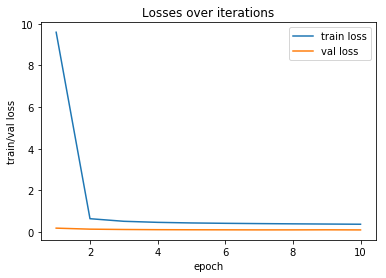

In [16]:
anp_tagger = ResnetTagger(len(ANP_classes))
anp_tagger = train(anp_tagger, "anp-tagger", trainXY, valXY, label_idx=1, augment_imgs=False)

Epoch 1 avg train loss 0.24306269019547075
Epoch 1 avg val loss   0.18736429970998034
Epoch 1 train+val time: 0:00:59 Total lapsed time: 0:00:59
Epoch 2 avg train loss 0.15753770066369888
Epoch 2 avg val loss   0.18329820266136757
Epoch 2 train+val time: 0:00:57 Total lapsed time: 0:01:57
Epoch 3 avg train loss 0.11616580276796133
Epoch 3 avg val loss   0.19786602029433617
Epoch 3 train+val time: 0:00:54 Total lapsed time: 0:02:52
Epoch 4 avg train loss 0.08018561235011214
Epoch 4 avg val loss   0.20842169798337495
Epoch 4 train+val time: 0:00:54 Total lapsed time: 0:03:46
Epoch 5 avg train loss 0.054494206194240266
Epoch 5 avg val loss   0.20889596984936643
Epoch 5 train+val time: 0:00:54 Total lapsed time: 0:04:41
Epoch 6 avg train loss 0.036265889588411496
Epoch 6 avg val loss   0.21282066863316756
Epoch 6 train+val time: 0:00:54 Total lapsed time: 0:05:35
Epoch 7 avg train loss 0.025328918470825897
Epoch 7 avg val loss   0.21951937045042337
Epoch 7 train+val time: 0:00:54 Total lap

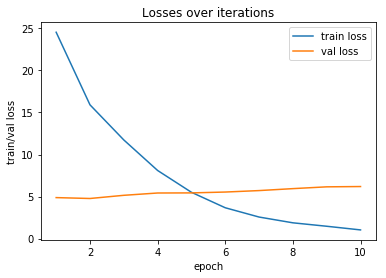

In [17]:
#Train adj multi-label classifier
# Factors affecting losses: (o) fewer classes (x) adj are abstract concepts; ResNet was trained to classify objects (noun-type) 
adj_tagger = ResnetTagger(n_classes=len(adj_classes))
adj_tagger = train(adj_tagger, 'adj-tagger', trainXY=trainXY, valXY=valXY, label_idx=2, augment_imgs=False)

### Load previously trained-and-saved models

In [8]:
anp_tagger = torch.load('trained-models/anp-tagger.pt')
adj_tagger = torch.load('trained-models/adj-tagger.pt')
noun_tagger = torch.load('trained-models/noun-tagger.pt')

In [ ]:
cross_anp_tagger_A = torch.load('trained-models/cross-anp-tagger-A.pt')
cross_anp_tagger_B = torch.load('trained-models/cross-anp-tagger-B.pt')
cross_anp_tagger_C = torch.load('trained-models/cross-anp-tagger-C.pt')

### See how models perform by inputting image and print the predicted labels

In [9]:
def visualise_pred(img_fn, model_classes_dict, dataset=fn_ANPs,
                   img_path=flickr8K_imgs, threshold=0.1):
    '''Use an image as input and compare the original tagging vs the model-predicted tagging'''
    
    #---------------------------------
    if img_fn in dataset:
        gold_labels = dataset[img_fn]
    else:
        gold_labels = None
        
    print(f"Gold labels:", gold_labels)
    #---------------------------------
    
    test_bat = file_to_tensor(img_path+img_fn).unsqueeze(0) # turn to a batchsize=1 tensor
    
    #---------------------------------
    for model, classes in model_classes_dict.items():
        model.eval()
        with torch.no_grad():
            test_bat = test_bat.to(device)
            out = model(test_bat)
            if len(out)>1: # cross_out, (a_out, n_out)
                out = out[0] 

        out=(out>threshold).float()
        predicted_indices = (out[0]==1.0).nonzero(as_tuple=True)[0] # indices of values that are 1
        predicted_labels = [classes[i] for i in predicted_indices]
        
        print(f"Predicted:", predicted_labels)
        print()
        
    #---------------------------------
    with Image.open(img_path+img_fn) as pic:
        plt.axis('off') # hide the axes on the sides
        plt.imshow(pic)
    
    

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]


/home/gusliahs@GU.GU.SE/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Predicted: [('black', 'dog'), ('white', 'dog'), ('brown', 'dog'), ('grassy', 'field')]



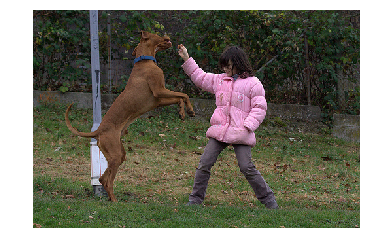

In [10]:
visualise_pred('2229509318_be3fef006b.jpg', {anp_tagger:ANP_classes}, threshold=0.03)

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]
Predicted: ['pink', 'little', 'brown', 'grassy']

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]
Predicted: ['girl', 'dog']



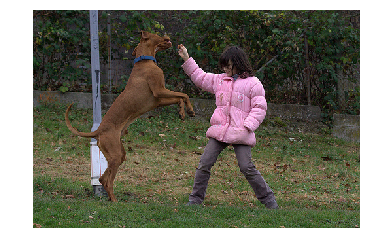

In [13]:
visualise_pred('2229509318_be3fef006b.jpg', {adj_tagger:adj_classes})
visualise_pred('2229509318_be3fef006b.jpg', {noun_tagger:noun_classes})

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]
Predicted: [('pink', 'girl'), ('pink', 'dog'), ('brown', 'girl'), ('brown', 'dog')]



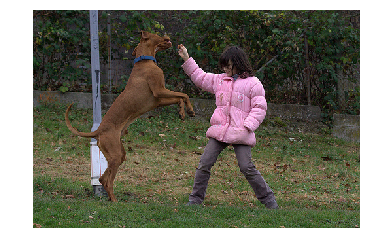

In [21]:
visualise_pred('2229509318_be3fef006b.jpg', {cross_anp_tagger_A:ANP_classes}, threshold=0.1)

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]
Predicted: [('little', 'girl'), ('brown', 'dog')]

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]
Predicted: [('brown', 'dog'), ('brown', 'shirt'), ('large', 'dog'), ('large', 'rock')]



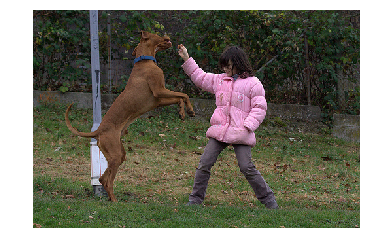

In [24]:
visualise_pred('2229509318_be3fef006b.jpg', {cross_anp_tagger_B:ANP_classes}, threshold=0.01) # res + reps
visualise_pred('2229509318_be3fef006b.jpg', {cross_anp_tagger_C:ANP_classes}, threshold=0.05) # res + sigs

Gold labels: [('snowy', 'field')]
Predicted: [('black', 'dog'), ('white', 'dog'), ('brown', 'dog'), ('small', 'dog'), ('large', 'dog'), ('tan', 'dog')]

Predicted: ['black', 'brown', 'snowy']

Predicted: ['dog', 'field']

Predicted: [('black', 'dog'), ('brown', 'dog'), ('brown', 'field'), ('young', 'dog'), ('snowy', 'dog')]

Predicted: []

Predicted: [('snowy', 'hill')]



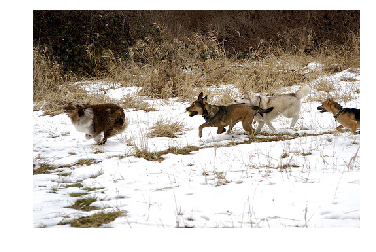

In [46]:
visualise_pred('3174196837_800689a2f3.jpg', models_and_classes, threshold=0.05)

Gold labels: [('purple', 'shirt'), ('blue', 'shirt')]
Predicted: [('young', 'man')]

Predicted: ['blue', 'purple']

Predicted: ['shirt']

Predicted: [('blue', 'hat'), ('blue', 'shirt'), ('blue', 'jacket'), ('blue', 'helmet'), ('purple', 'hat'), ('purple', 'shirt'), ('purple', 'helmet')]

Predicted: []

Predicted: [('blue', 'shirt'), ('purple', 'shirt')]



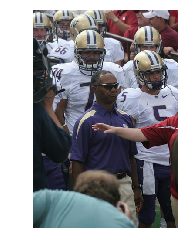

In [43]:
visualise_pred('241347547_902725b9f8.jpg', models_and_classes)

Gold labels: None
Predicted: [('black', 'dog'), ('white', 'dog'), ('brown', 'dog')]

Predicted: ['pink', 'little', 'white', 'young', 'purple']

Predicted: ['dog']

Predicted: [('pink', 'dress'), ('pink', 'girl'), ('pink', 'dog'), ('pink', 'hat'), ('pink', 'shirt'), ('purple', 'girl'), ('purple', 'shirt')]

Predicted: [('little', 'girl'), ('young', 'girl')]

Predicted: [('pink', 'shirt'), ('little', 'girl'), ('young', 'girl')]



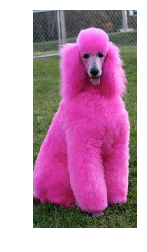

In [31]:
fn = 'pinkdog1.jpg'
visualise_pred(fn, models_and_classes, img_path='', threshold=0.08)

Gold labels: None
Predicted: [('little', 'girl'), ('young', 'girl'), ('young', 'boy')]

Predicted: ['pink', 'little', 'young']

Predicted: ['dog']

Predicted: [('pink', 'dress'), ('pink', 'girl'), ('pink', 'shirt'), ('little', 'dress'), ('little', 'girl'), ('little', 'shirt'), ('young', 'girl'), ('young', 'shirt'), ('red', 'girl'), ('red', 'shirt'), ('purple', 'girl')]

Predicted: [('little', 'girl'), ('young', 'girl')]

Predicted: [('little', 'girl'), ('young', 'girl')]



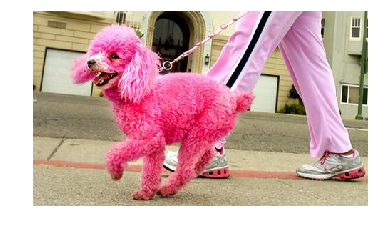

In [38]:
# fn = 'green-dogs.jpg'

fn = 'pinkdog2.jpg'
visualise_pred(fn, models_and_classes, img_path='', threshold=0.15)
